In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, precision_recall_fscore_support)
import seaborn as sns

In [41]:
ROOT = "./"

monday = pd.read_csv(ROOT + "Monday-WorkingHours.pcap_ISCX.csv")
wednesday = pd.read_csv(ROOT + "Wednesday-workingHours.pcap_ISCX.csv")
dataset = pd.concat([monday, wednesday], ignore_index=True)

# 1. Dataset Analysis and Preprocessing
## 1.1 Dataset Exploration

In [42]:

print(f"Total samples in dataset: {len(dataset):,}")
print(f"  - Monday (benign): {len(monday):,}")
print(f"  - Wednesday (attack): {len(wednesday):,}")

print(f"\nTotal features: {dataset.shape[1]}")
print(f"Feature columns: {dataset.shape[1] - 1} (excluding label)")
print(f"\nFeature names:")
for i, col in enumerate(dataset.columns, 1):
    print(f"  {i:2d}. {col}")

print(f"\nLabel distribution:")
label_counts = dataset[' Label'].value_counts()
for label, count in label_counts.items():
    percentage = (count / len(dataset)) * 100
    print(f"  {label:20s}: {count:7,} samples ({percentage:5.2f}%)")

print(f"\nSummary:")
benign_count = (dataset[' Label'] == 'BENIGN').sum()
attack_count = (dataset[' Label'] != 'BENIGN').sum()
print(f"  Normal traffic (BENIGN): {benign_count:,} ({benign_count/len(dataset)*100:.2f}%)")
print(f"  Attack traffic:          {attack_count:,} ({attack_count/len(dataset)*100:.2f}%)")
print(f"  Number of attack types:  {len(label_counts) - 1}")

Total samples in dataset: 1,222,621
  - Monday (benign): 529,918
  - Wednesday (attack): 692,703

Total features: 79
Feature columns: 78 (excluding label)

Feature names:
   1.  Destination Port
   2.  Flow Duration
   3.  Total Fwd Packets
   4.  Total Backward Packets
   5. Total Length of Fwd Packets
   6.  Total Length of Bwd Packets
   7.  Fwd Packet Length Max
   8.  Fwd Packet Length Min
   9.  Fwd Packet Length Mean
  10.  Fwd Packet Length Std
  11. Bwd Packet Length Max
  12.  Bwd Packet Length Min
  13.  Bwd Packet Length Mean
  14.  Bwd Packet Length Std
  15. Flow Bytes/s
  16.  Flow Packets/s
  17.  Flow IAT Mean
  18.  Flow IAT Std
  19.  Flow IAT Max
  20.  Flow IAT Min
  21. Fwd IAT Total
  22.  Fwd IAT Mean
  23.  Fwd IAT Std
  24.  Fwd IAT Max
  25.  Fwd IAT Min
  26. Bwd IAT Total
  27.  Bwd IAT Mean
  28.  Bwd IAT Std
  29.  Bwd IAT Max
  30.  Bwd IAT Min
  31. Fwd PSH Flags
  32.  Bwd PSH Flags
  33.  Fwd URG Flags
  34.  Bwd URG Flags
  35.  Fwd Header Length
  3

In [43]:
# Get numerical columns
numerical_cols = dataset.select_dtypes(include=['int64', 'float64']).columns
print(f"\nNumerical features: {len(numerical_cols)}\n")

# Create comprehensive statistics dataframe
stats_df = dataset[numerical_cols].describe().T
stats_df['missing'] = dataset[numerical_cols].isnull().sum()
stats_df['missing_pct'] = (stats_df['missing'] / len(dataset) * 100).round(2)

# Check for infinite values
inf_counts = dataset[numerical_cols].apply(lambda x: x.isin([float('inf'), float('-inf')]).sum())
stats_df['inf_values'] = inf_counts

# Reorder columns for better readability
stats_df = stats_df[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'missing', 'missing_pct', 'inf_values']]

# Configure display options for nice formatting
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Display the table (Jupyter will render it as HTML)
display(stats_df)

# Summary statistics
total_missing = stats_df['missing'].sum()
features_with_missing = (stats_df['missing'] > 0).sum()
total_inf = stats_df['inf_values'].sum()
features_with_inf = (stats_df['inf_values'] > 0).sum()

print("\nSummary of Missing and Infinite Values:")
print("Total features:", len(numerical_cols))
print("Features with missing values:", features_with_missing)
print("Total missing values:", f"{total_missing:,}")
print("Features with infinite values:", features_with_inf)
print("Total infinite values:", f"{total_inf:,}")


Numerical features: 78



C:\Users\ianis\AppData\Roaming\Python\Python313\site-packages\pandas\core\nanops.py:1020: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\ianis\AppData\Roaming\Python\Python313\site-packages\pandas\core\nanops.py:1020: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,count,mean,std,min,25%,50%,75%,max,missing,missing_pct,inf_values
Destination Port,1222621.0000,7835.5870,18560.4085,0.0000,53.0000,80.0000,443.0000,65535.0000,0,0.0000,0
Flow Duration,1222621.0000,20367971.8026,38350196.1115,-1.0000,188.0000,48030.0000,6074464.0000,119999998.0000,0,0.0000,0
Total Fwd Packets,1222621.0000,9.9178,813.3275,1.0000,2.0000,2.0000,6.0000,219759.0000,0,0.0000,0
Total Backward Packets,1222621.0000,10.7788,1070.2825,0.0000,1.0000,2.0000,6.0000,291922.0000,0,0.0000,0
Total Length of Fwd Packets,1222621.0000,545.2657,6191.9183,0.0000,12.0000,74.0000,359.0000,1323378.0000,0,0.0000,0
Total Length of Bwd Packets,1222621.0000,17387.3794,2438923.4127,0.0000,0.0000,164.0000,2836.0000,655453030.0000,0,0.0000,0
Fwd Packet Length Max,1222621.0000,215.0880,542.4823,0.0000,6.0000,43.0000,323.0000,24820.0000,0,0.0000,0
Fwd Packet Length Min,1222621.0000,17.2999,45.3296,0.0000,0.0000,0.0000,36.0000,2293.0000,0,0.0000,0
Fwd Packet Length Mean,1222621.0000,56.3029,133.3025,0.0000,6.0000,39.3333,55.0000,4640.7576,0,0.0000,0
Fwd Packet Length Std,1222621.0000,71.8679,196.0462,0.0000,0.0000,0.0000,115.4774,7125.5968,0,0.0000,0



Summary of Missing and Infinite Values:
Total features: 78
Features with missing values: 1
Total missing values: 1,072
Features with infinite values: 2
Total infinite values: 2,396


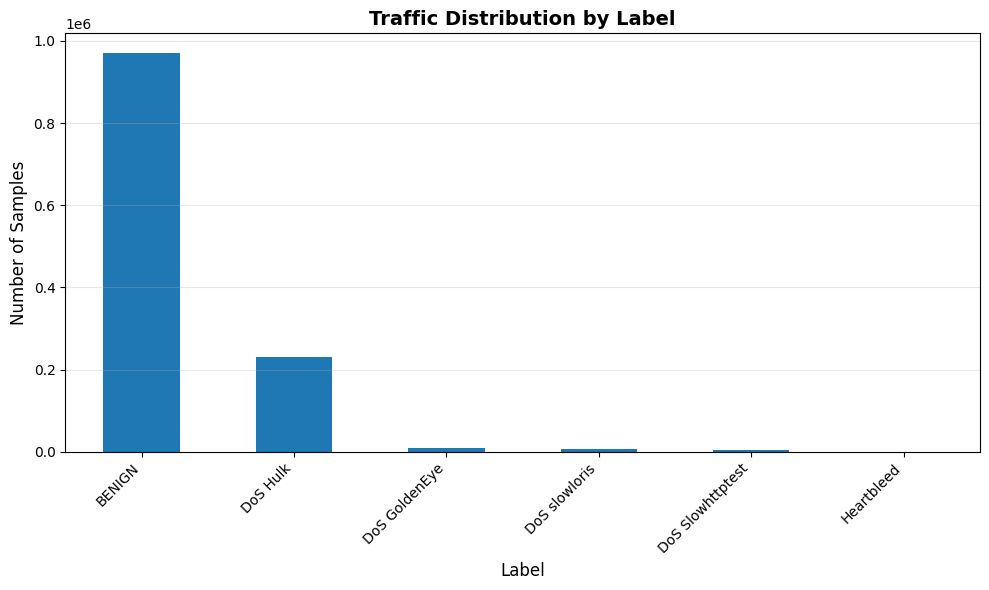

In [44]:
# Bar chart
plt.figure(figsize=(10, 6))
label_counts = dataset[' Label'].value_counts()
label_counts.plot(kind='bar')
plt.title('Traffic Distribution by Label', fontsize=14, fontweight='bold')
plt.xlabel('Label', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 1.2 Dataset Preprocessing

In [45]:
# Data cleaning
# Create a copy to avoid modifying the original dataset
df_processed = dataset.copy()

print(f"Initial shape: {df_processed.shape}")

# Handle missing values
missing_before = df_processed.isnull().sum().sum()
print(f"\nMissing values before cleaning: {missing_before}")

# Fill or drop missing values (strategy: drop rows with missing values)
df_processed = df_processed.dropna()
print(f"Missing values after cleaning: {df_processed.isnull().sum().sum()}")

# Handle infinite values
print(f"\nHandling infinite values...")
numerical_cols = df_processed.select_dtypes(include=['int64', 'float64']).columns
numerical_cols = numerical_cols.drop(' Label', errors='ignore')

# Replace infinite values with NaN, then replace with column median
for col in numerical_cols:
    inf_mask = df_processed[col].isin([float('inf'), float('-inf')])
    if inf_mask.any():
        print(f"  - Found {inf_mask.sum()} infinite values in '{col}'")
        df_processed.loc[inf_mask, col] = df_processed[col].replace([float('inf'), float('-inf')], float('nan'))
        df_processed[col].fillna(df_processed[col].median(), inplace=True)

###################################################################
# Added because dropping rows with NaN after replacing inf with NaN
df_processed = df_processed.dropna()
print(f"\nFinal shape after cleaning: {df_processed.shape}")
###################################################################

print(f"Missing values after cleaning: {df_processed.isnull().sum().sum()}")

print(f"Rows removed: {len(dataset) - len(df_processed)}")

Initial shape: (1222621, 79)

Missing values before cleaning: 1072
Missing values after cleaning: 0

Handling infinite values...
  - Found 662 infinite values in 'Flow Bytes/s'


C:\Users\ianis\AppData\Local\Temp\ipykernel_29332\2176773258.py:26: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment using an inplace method.
Such inplace method never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' instead, to perform the operation inplace on the original object, or try to avoid an inplace operation using 'df[col] = df[col].method(value)'.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html
  df_processed[col].fillna(df_processed[col].median(), inplace=True)
C:\Users\ianis\AppData\Local\Temp\ipykernel_29332\2176773258.py:26: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series throug

  - Found 662 infinite values in ' Flow Packets/s'

Final shape after cleaning: (1220887, 79)
Missing values after cleaning: 0
Rows removed: 1734


In [46]:
# Separate features (X) and labels (y)
X = df_processed.drop(' Label', axis=1)
y = df_processed[' Label']

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"\nLabel distribution:")
print(y.value_counts())

Features shape: (1220887, 78)
Labels shape: (1220887,)

Label distribution:
 Label
BENIGN              969164
DoS Hulk            230124
DoS GoldenEye        10293
DoS slowloris         5796
DoS Slowhttptest      5499
Heartbleed              11
Name: count, dtype: int64


In [47]:
# Encoding categorical features

# Check for categorical features in X
categorical_features = X.select_dtypes(include=['object']).columns
print(f"\nCategorical features in X: {list(categorical_features)}")

if len(categorical_features) > 0:
    print(f"Found {len(categorical_features)} categorical feature(s) to encode")
    # Apply One-Hot Encoding for categorical features if any exist
    for col in categorical_features:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        print(f"  - Encoded '{col}'")
else:
    print("No categorical features found in features (X) - all features are numerical")

# Encode target labels (y) - convert attack names to numerical labels
print(f"\nEncoding target labels (y)...")
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Label mapping:")
for idx, label in enumerate(label_encoder.classes_):
    print(f"  {label:20s} → {idx}")

print(f"\nEncoded labels shape: {y_encoded.shape}")


Categorical features in X: []
No categorical features found in features (X) - all features are numerical

Encoding target labels (y)...
Label mapping:
  BENIGN               → 0
  DoS GoldenEye        → 1
  DoS Hulk             → 2
  DoS Slowhttptest     → 3
  DoS slowloris        → 4
  Heartbleed           → 5

Encoded labels shape: (1220887,)


In [48]:
# Feature Standardization (Z-Score Normalization)
scaler = StandardScaler()

# Fit and transform the features
X_scaled = scaler.fit_transform(X)

print(f"Original features shape: {X.shape}")
print(f"Scaled features shape: {X_scaled.shape}")

# Show statistics before and after scaling
print(f"\nBefore scaling (first feature):")
print(f"  Mean: {X.iloc[:, 0].mean():.4f}")
print(f"  Std:  {X.iloc[:, 0].std():.4f}")
print(f"  Min:  {X.iloc[:, 0].min():.4f}")
print(f"  Max:  {X.iloc[:, 0].max():.4f}")

print(f"\nAfter scaling (first feature):")
print(f"  Mean: {X_scaled[:, 0].mean():.4f}")
print(f"  Std:  {X_scaled[:, 0].std():.4f}")
print(f"  Min:  {X_scaled[:, 0].min():.4f}")
print(f"  Max:  {X_scaled[:, 0].max():.4f}")

print("\n✓ Features standardized using StandardScaler (mean=0, std=1)")

Original features shape: (1220887, 78)
Scaled features shape: (1220887, 78)

Before scaling (first feature):
  Mean: 7828.8615
  Std:  18553.8095
  Min:  0.0000
  Max:  65535.0000

After scaling (first feature):
  Mean: -0.0000
  Std:  1.0000
  Min:  -0.4220
  Max:  3.1102

✓ Features standardized using StandardScaler (mean=0, std=1)


In [49]:
# Dataset Splitting (70% Train, 15% Validation, 15% Test)

# First split: separate test set (15% of total data)
# stratify ensures attack distribution is maintained in all sets
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y_encoded, 
    test_size=0.15, 
    random_state=42, 
    stratify=y_encoded
)

# Second split: separate training and validation from remaining 85%
# 70% train + 15% validation = 85% total
# To get 15% validation from 85%: 15/85 ≈ 0.176
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.176, 
    random_state=42, 
    stratify=y_temp
)

print(f"\nDataset split completed:")
print(f"  Training set:   {X_train.shape[0]:6,} samples ({X_train.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"  Validation set: {X_val.shape[0]:6,} samples ({X_val.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"  Test set:       {X_test.shape[0]:6,} samples ({X_test.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"  Total:          {len(X_scaled):6,} samples (100.0%)")

# Verify stratification - check label distribution in each set
print(f"\nLabel distribution verification:")

for set_name, y_set in [("Training", y_train), ("Validation", y_val), ("Test", y_test)]:
    unique, counts = np.unique(y_set, return_counts=True)
    print(f"\n  {set_name} set:")
    for label_idx, count in zip(unique, counts):
        label_name = label_encoder.classes_[label_idx]
        percentage = (count / len(y_set)) * 100
        print(f"    {label_name:20s}: {count:6,} ({percentage:5.2f}%)")


Dataset split completed:
  Training set:   855,108 samples (70.0%)
  Validation set: 182,645 samples (15.0%)
  Test set:       183,134 samples (15.0%)
  Total:          1,220,887 samples (100.0%)

Label distribution verification:

  Training set:
    BENIGN              : 678,802 (79.38%)
    DoS GoldenEye       :  7,209 ( 0.84%)
    DoS Hulk            : 161,179 (18.85%)
    DoS Slowhttptest    :  3,851 ( 0.45%)
    DoS slowloris       :  4,060 ( 0.47%)
    Heartbleed          :      7 ( 0.00%)

  Validation set:
    BENIGN              : 144,987 (79.38%)
    DoS GoldenEye       :  1,540 ( 0.84%)
    DoS Hulk            : 34,426 (18.85%)
    DoS Slowhttptest    :    823 ( 0.45%)
    DoS slowloris       :    867 ( 0.47%)
    Heartbleed          :      2 ( 0.00%)

  Test set:
    BENIGN              : 145,375 (79.38%)
    DoS GoldenEye       :  1,544 ( 0.84%)
    DoS Hulk            : 34,519 (18.85%)
    DoS Slowhttptest    :    825 ( 0.45%)
    DoS slowloris       :    869 ( 0.47%)
  

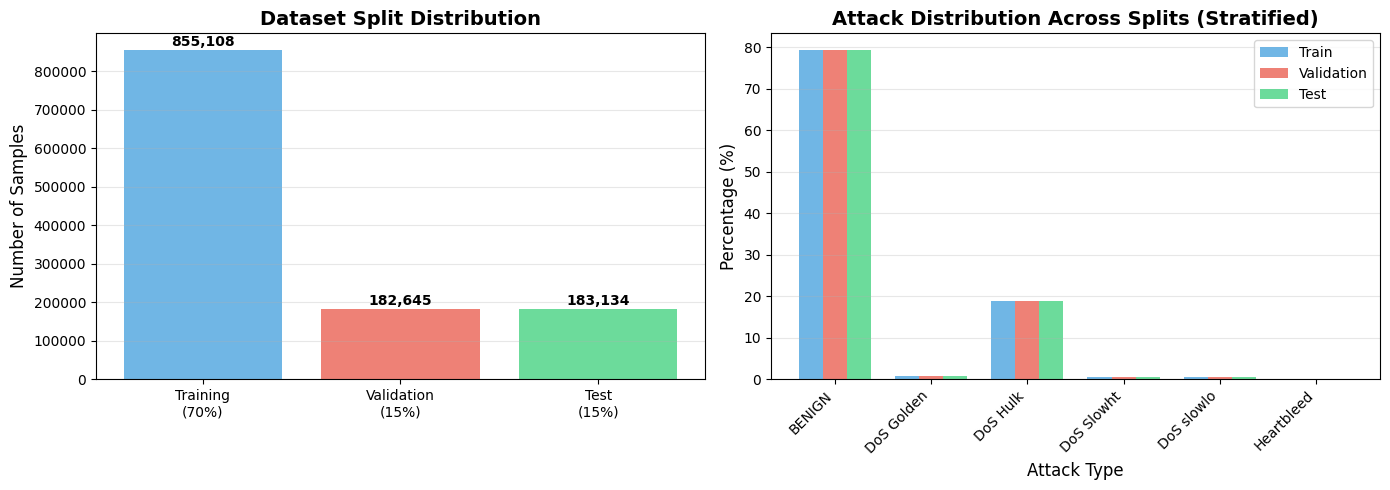

In [50]:
# Visualize the data split
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Split sizes
split_sizes = [len(X_train), len(X_val), len(X_test)]
split_labels = ['Training\n(70%)', 'Validation\n(15%)', 'Test\n(15%)']
colors = ['#3498db', '#e74c3c', '#2ecc71']

axes[0].bar(split_labels, split_sizes, color=colors, alpha=0.7)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].set_title('Dataset Split Distribution', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (label, size) in enumerate(zip(split_labels, split_sizes)):
    axes[0].text(i, size + 1000, f'{size:,}', ha='center', va='bottom', fontweight='bold')

# Attack distribution across splits
train_dist = np.bincount(y_train) / len(y_train) * 100
val_dist = np.bincount(y_val) / len(y_val) * 100
test_dist = np.bincount(y_test) / len(y_test) * 100

x = np.arange(len(label_encoder.classes_))
width = 0.25

axes[1].bar(x - width, train_dist, width, label='Train', color=colors[0], alpha=0.7)
axes[1].bar(x, val_dist, width, label='Validation', color=colors[1], alpha=0.7)
axes[1].bar(x + width, test_dist, width, label='Test', color=colors[2], alpha=0.7)

axes[1].set_xlabel('Attack Type', fontsize=12)
axes[1].set_ylabel('Percentage (%)', fontsize=12)
axes[1].set_title('Attack Distribution Across Splits (Stratified)', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels([label[:10] for label in label_encoder.classes_], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Classical Machine Learning Models for IDS
## 2.1. Logistic Regression for Intrusion Detection

In [51]:
# Train Logistic Regression model

# Initialize model with parameters suitable for multi-class classification
lr_model = LogisticRegression(
    max_iter=1000,
    #multi_class='ovr',  # One-vs-Rest for multi-class
    random_state=42,
    #n_jobs=-1,
    verbose=1
)

# Train the model
print("\nTraining model on training set...")
lr_model.fit(X_train, y_train)
print("Model training completed")

# Make predictions
print("\nMaking predictions...")
y_train_pred = lr_model.predict(X_train)
y_val_pred = lr_model.predict(X_val)
y_test_pred = lr_model.predict(X_test)

# Get prediction probabilities for ROC-AUC
y_train_proba = lr_model.predict_proba(X_train)
y_val_proba = lr_model.predict_proba(X_val)
y_test_proba = lr_model.predict_proba(X_test)

print("Predictions completed")


Training model on training set...
Model training completed

Making predictions...
Predictions completed


In [52]:
# Evaluation Metrics

# Calculate metrics for each dataset
for set_name, y_true, y_pred, y_proba in [
    ("Training", y_train, y_train_pred, y_train_proba),
    ("Validation", y_val, y_val_pred, y_val_proba),
    ("Test", y_test, y_test_pred, y_test_proba)
]:
    print(f"\n{set_name} Set Performance:")
    
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # Precision, Recall, F1-Score (weighted average for multi-class)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    print(f"Precision: {precision:.4f} (weighted avg)")
    print(f"Recall:    {recall:.4f} (weighted avg)")
    print(f"F1-Score:  {f1:.4f} (weighted avg)")
    
    # ROC-AUC (One-vs-Rest for multi-class)
    try:
        roc_auc = roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted')
        print(f"ROC-AUC:   {roc_auc:.4f} (weighted avg)")
    except Exception as e:
        print(f"ROC-AUC:   Could not compute ({str(e)})")


Training Set Performance:
Accuracy:  0.9941 (99.41%)
Precision: 0.9941 (weighted avg)
Recall:    0.9941 (weighted avg)
F1-Score:  0.9941 (weighted avg)
ROC-AUC:   0.9995 (weighted avg)

Validation Set Performance:
Accuracy:  0.9942 (99.42%)
Precision: 0.9941 (weighted avg)
Recall:    0.9942 (weighted avg)
F1-Score:  0.9941 (weighted avg)
ROC-AUC:   0.9995 (weighted avg)

Test Set Performance:
Accuracy:  0.9943 (99.43%)
Precision: 0.9943 (weighted avg)
Recall:    0.9943 (weighted avg)
F1-Score:  0.9943 (weighted avg)
ROC-AUC:   0.9995 (weighted avg)


In [53]:
# Detailed classification report for the test set

# Generate classification report
target_names = label_encoder.classes_
report = classification_report(y_test, y_test_pred, target_names=target_names, zero_division=0)
print(report)

precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
    y_test, y_test_pred, labels=range(len(target_names)), zero_division=0
)

metrics_df = pd.DataFrame({
    'Attack Type': target_names,
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class,
    'Support': support_per_class
})

print("\nPer-Class Metrics Summary:")
display(metrics_df)

                  precision    recall  f1-score   support

          BENIGN       1.00      1.00      1.00    145375
   DoS GoldenEye       0.96      0.90      0.93      1544
        DoS Hulk       0.99      1.00      0.99     34519
DoS Slowhttptest       0.93      0.92      0.92       825
   DoS slowloris       0.91      0.83      0.87       869
      Heartbleed       0.67      1.00      0.80         2

        accuracy                           0.99    183134
       macro avg       0.91      0.94      0.92    183134
    weighted avg       0.99      0.99      0.99    183134


Per-Class Metrics Summary:


,Attack Type,Precision,Recall,F1-Score,Support
0,BENIGN,0.9976,0.9958,0.9967,145375
1,DoS GoldenEye,0.9646,0.9009,0.9317,1544
2,DoS Hulk,0.9856,0.9982,0.9919,34519
3,DoS Slowhttptest,0.9254,0.9176,0.9215,825
4,DoS slowloris,0.9057,0.8285,0.8654,869
5,Heartbleed,0.6667,1.0000,0.8000,2


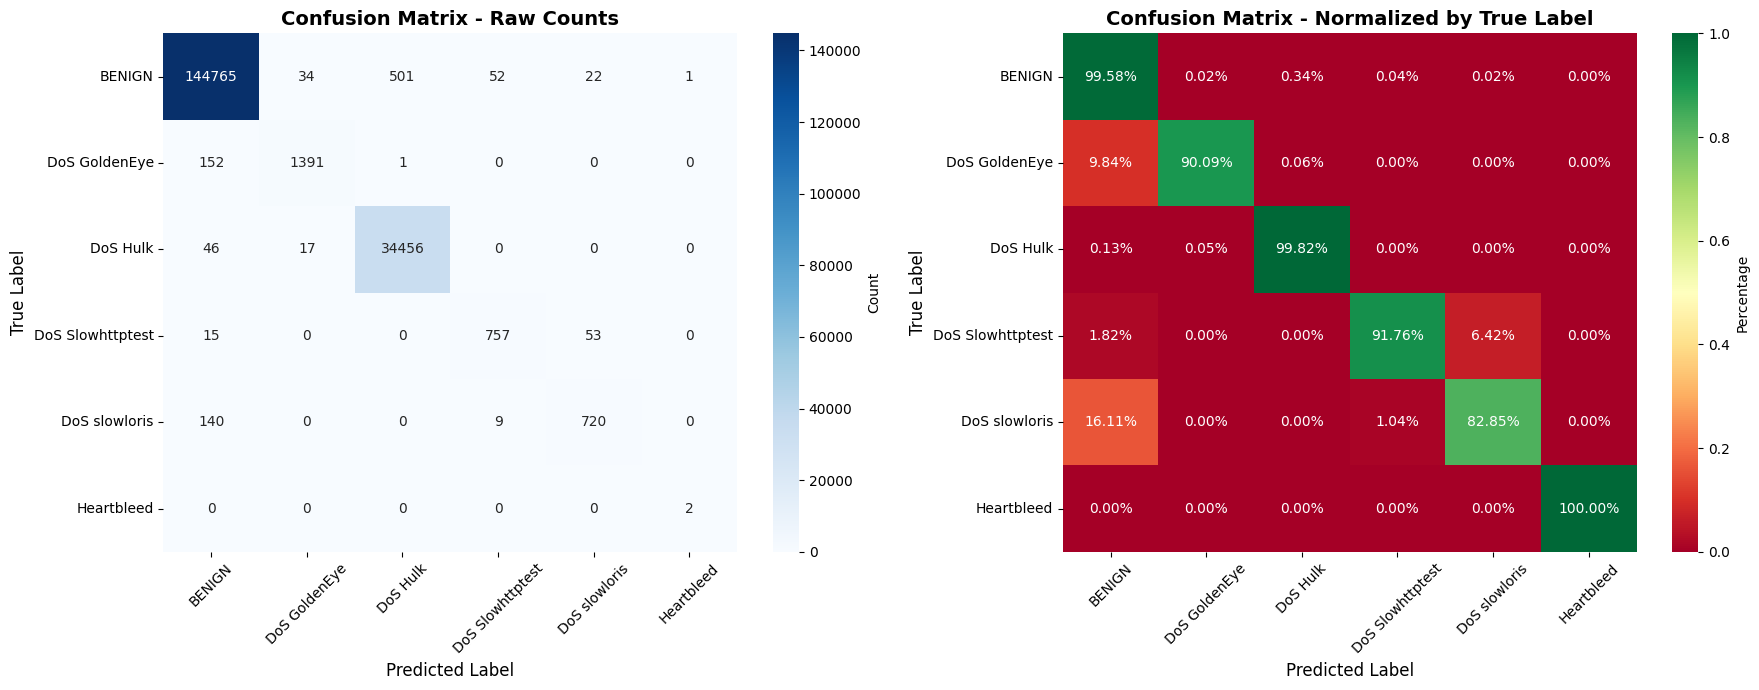


Key Observations from Confusion Matrix:
BENIGN              : 144,765/145,375 correct (99.58%)
DoS GoldenEye       :  1,391/ 1,544 correct (90.09%)
DoS Hulk            : 34,456/34,519 correct (99.82%)
DoS Slowhttptest    :    757/   825 correct (91.76%)
DoS slowloris       :    720/   869 correct (82.85%)
Heartbleed          :      2/     2 correct (100.00%)


In [73]:
# Confusion Matrix Visualization

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=target_names, yticklabels=target_names,
            cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix - Raw Counts', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

# Plot 2: Normalized (percentage per true class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn', ax=axes[1],
            xticklabels=target_names, yticklabels=target_names,
            cbar_kws={'label': 'Percentage'}, vmin=0, vmax=1)
axes[1].set_title('Confusion Matrix - Normalized by True Label', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

# Print key observations
print("\nKey Observations from Confusion Matrix:")

# Diagonal elements (correct predictions)
correct_predictions = np.diag(cm)
total_per_class = cm.sum(axis=1)

for i, class_name in enumerate(target_names):
    accuracy_per_class = correct_predictions[i] / total_per_class[i] if total_per_class[i] > 0 else 0
    print(f"{class_name:20s}: {correct_predictions[i]:6,}/{total_per_class[i]:6,} correct ({accuracy_per_class*100:5.2f}%)")


False Positives and False Negatives by Class:


,Attack Type,True Positives,False Positives,False Negatives,FP Rate,FN Rate
0,BENIGN,144765,353,610,0.0093,0.0042
1,DoS GoldenEye,1391,51,153,0.0003,0.0991
2,DoS Hulk,34456,502,63,0.0034,0.0018
3,DoS Slowhttptest,757,61,68,0.0003,0.0824
4,DoS slowloris,720,75,149,0.0004,0.1715
5,Heartbleed,2,1,0,0.0000,0.0000



Overall Statistics:
  Total False Positives: 1,043 (0.57%)
  Total False Negatives: 1,043 (0.57%)


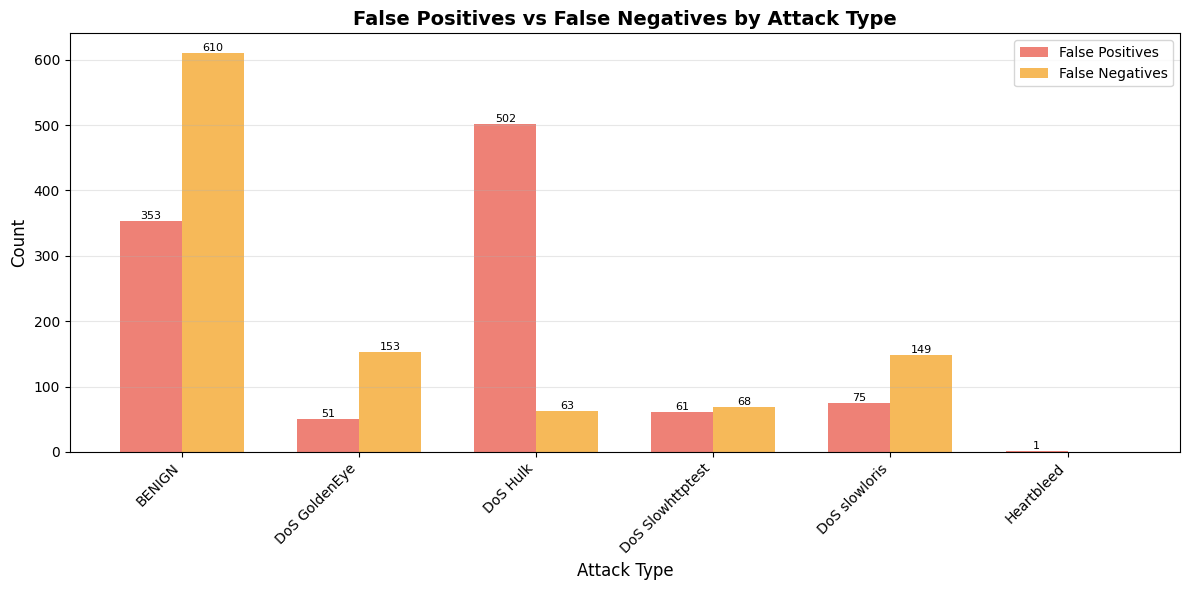

In [74]:
# False Positives vs False Negatives Analysis

# Calculate FP and FN for each class
false_positives = cm.sum(axis=0) - np.diag(cm)  # Sum of column - diagonal
false_negatives = cm.sum(axis=1) - np.diag(cm)  # Sum of row - diagonal
true_positives = np.diag(cm)
true_negatives = cm.sum() - (false_positives + false_negatives + true_positives)

# Create summary table
fp_fn_df = pd.DataFrame({
    'Attack Type': target_names,
    'True Positives': true_positives,
    'False Positives': false_positives,
    'False Negatives': false_negatives,
    'FP Rate': false_positives / (false_positives + true_negatives) if (false_positives + true_negatives).any() else 0,
    'FN Rate': false_negatives / (false_negatives + true_positives)
})

print("\nFalse Positives and False Negatives by Class:")
display(fp_fn_df)

# Overall FP and FN
total_fp = false_positives.sum()
total_fn = false_negatives.sum()
total_predictions = cm.sum()

print(f"\nOverall Statistics:")
print(f"  Total False Positives: {total_fp:,} ({total_fp/total_predictions*100:.2f}%)")
print(f"  Total False Negatives: {total_fn:,} ({total_fn/total_predictions*100:.2f}%)")

# Visualize FP vs FN
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(target_names))
width = 0.35

bars1 = ax.bar(x - width/2, false_positives, width, label='False Positives', color='#e74c3c', alpha=0.7)
bars2 = ax.bar(x + width/2, false_negatives, width, label='False Negatives', color='#f39c12', alpha=0.7)

ax.set_xlabel('Attack Type', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('False Positives vs False Negatives by Attack Type', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(target_names, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height):,}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# 3. Ensemble-Based IDS and Performance Trade-offs
## 3.1. Random Forest for Intrusion Detection

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import time

# As the training set is large, our first tries with GridSearchCV were very slow.
# We thus chose to reduce the tuning dataset size and simplify the grid search, in order to get results faster.
X_tune, _, y_tune, _ = train_test_split(
    X_train, y_train,
    train_size=0.2,  # 20% of training set used for tuning
    random_state=42,
    stratify=y_train  # Important to keep proportions
)

print(f"Tuning on {X_tune.shape[0]:,} samples (instead of {X_train.shape[0]:,})")


param_grid = {
    'n_estimators': [50, 100, 150, 250],  
    'max_depth': [None, 20, 30, 40],       
}

start_time = time.time()

# To optimize time further, we reduce the number of folds and use fewer resources in GridSearchCV
# Each tree uses only 20% of data from the tuning set (max_samples=0.2) to speed up training even more
grid_search = GridSearchCV(
    RandomForestClassifier(
        max_samples=0.2,      # 20% of data per tree
        n_jobs=-1,            
        random_state=42,
        verbose=0
    ),
    param_grid,
    cv=3,                     # 3 folds instead of 5
    n_jobs=1,                 # IMPORTANT: 1 if RandomForest has n_jobs=-1
    verbose=10,               # Show progress
    scoring='accuracy'
)

grid_search.fit(X_tune, y_tune)

elapsed = time.time() - start_time
print(f"\nTTotal time: {elapsed/60:.1f} minutes")

# 4. Best parameters
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_:.4f}")

Tuning sur 171,021 échantillons (au lieu de 855,108)
Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3; 1/16] START max_depth=None, n_estimators=50............................


C:\Users\ianis\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_split.py:813: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[CV 1/3; 1/16] END max_depth=None, n_estimators=50;, score=0.999 total time=   1.7s
[CV 2/3; 1/16] START max_depth=None, n_estimators=50............................
[CV 2/3; 1/16] END max_depth=None, n_estimators=50;, score=0.999 total time=   1.4s
[CV 3/3; 1/16] START max_depth=None, n_estimators=50............................
[CV 3/3; 1/16] END max_depth=None, n_estimators=50;, score=0.999 total time=   1.4s
[CV 1/3; 2/16] START max_depth=None, n_estimators=100...........................
[CV 1/3; 2/16] END max_depth=None, n_estimators=100;, score=0.999 total time=   2.4s
[CV 2/3; 2/16] START max_depth=None, n_estimators=100...........................
[CV 2/3; 2/16] END max_depth=None, n_estimators=100;, score=0.999 total time=   2.5s
[CV 3/3; 2/16] START max_depth=None, n_estimators=100...........................
[CV 3/3; 2/16] END max_depth=None, n_estimators=100;, score=0.999 total time=   2.6s
[CV 1/3; 3/16] START max_depth=None, n_estimators=150...........................
[CV 1/3

In [57]:
best_n_estimators = grid_search.best_params_['n_estimators']
best_max_depth = grid_search.best_params_['max_depth']

print("The best number of estimators is:", best_n_estimators)
print("The best max depth is:", best_max_depth)

rf_model = RandomForestClassifier(
    n_estimators=best_n_estimators,   # Number of trees
    max_depth=best_max_depth
)

The best number of estimators is: 250
The best max depth is: 20


In [ ]:
# Once the best parameters are found, train the Random Forest model on the entire training set
print("\nTraining Random Forest model on the entire training set with best parameters...")

rf_model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",250
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",20
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

In [59]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

target_names = label_encoder.classes_
## Predictions
y_tree_pred = rf_model.predict(X_test)

## Performance metrics
print("Accuracy:", accuracy_score(y_test, y_tree_pred))
print("\nClassification Report:\n",
      classification_report(y_test, y_tree_pred, target_names=target_names))

Accuracy: 0.9995194775410355

Classification Report:
                   precision    recall  f1-score   support

          BENIGN       1.00      1.00      1.00    145375
   DoS GoldenEye       0.99      1.00      1.00      1544
        DoS Hulk       1.00      1.00      1.00     34519
DoS Slowhttptest       1.00      0.99      0.99       825
   DoS slowloris       0.99      1.00      0.99       869
      Heartbleed       1.00      1.00      1.00         2

        accuracy                           1.00    183134
       macro avg       1.00      1.00      1.00    183134
    weighted avg       1.00      1.00      1.00    183134



In [60]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

target_names = label_encoder.classes_
## Predictions
y_tree_pred_val = rf_model.predict(X_val)

## Performance metrics
print("Accuracy:", accuracy_score(y_val, y_tree_pred_val))
print("\nClassification Report:\n",
      classification_report(y_val, y_tree_pred_val, target_names=target_names))

Accuracy: 0.9995674669440718

Classification Report:
                   precision    recall  f1-score   support

          BENIGN       1.00      1.00      1.00    144987
   DoS GoldenEye       1.00      0.99      1.00      1540
        DoS Hulk       1.00      1.00      1.00     34426
DoS Slowhttptest       1.00      1.00      1.00       823
   DoS slowloris       1.00      0.99      1.00       867
      Heartbleed       1.00      1.00      1.00         2

        accuracy                           1.00    182645
       macro avg       1.00      1.00      1.00    182645
    weighted avg       1.00      1.00      1.00    182645



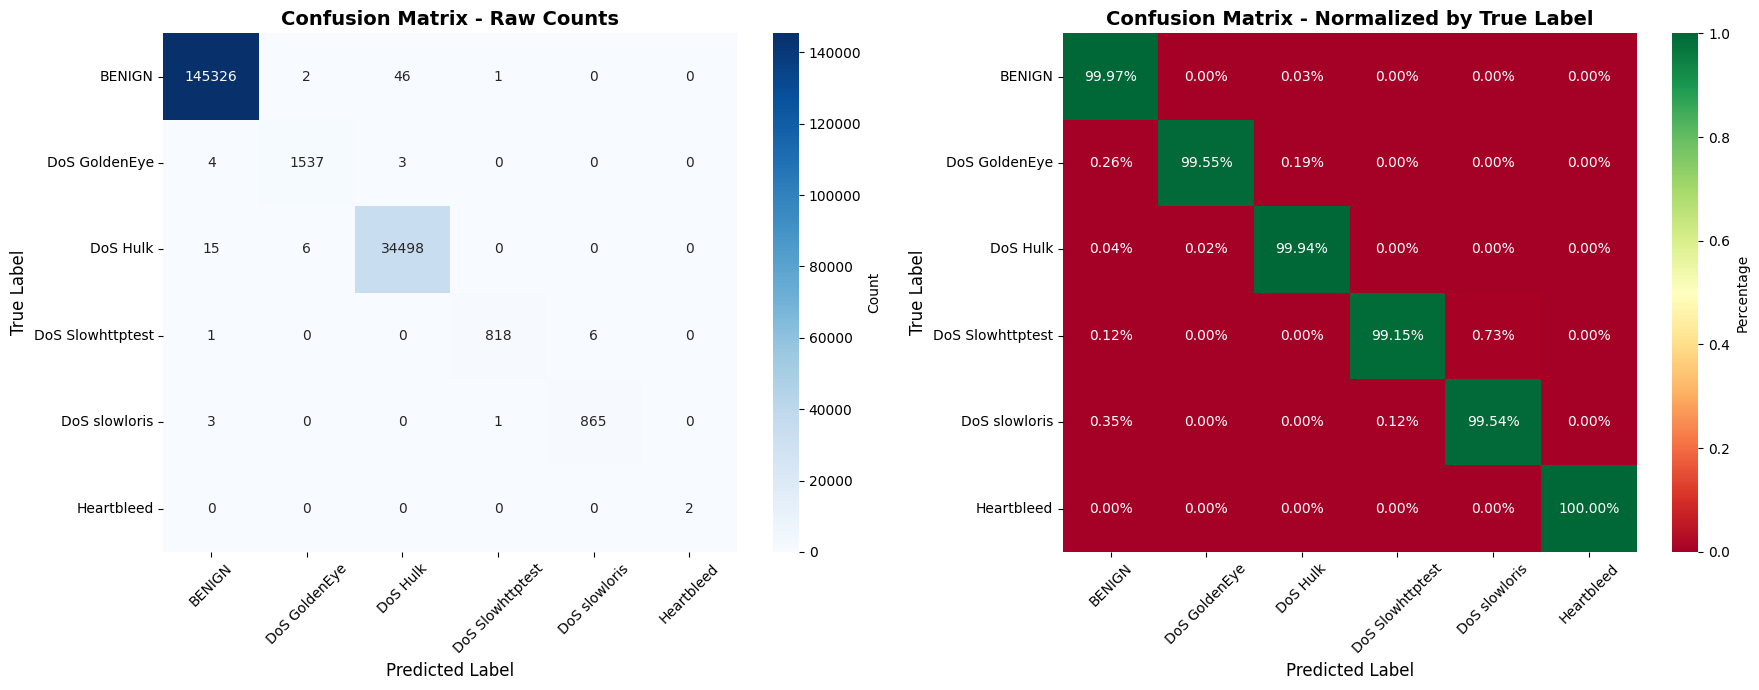


Key Observations from Confusion Matrix:
BENIGN              : 145,326/145,375 correct (99.97%)
DoS GoldenEye       :  1,537/ 1,544 correct (99.55%)
DoS Hulk            : 34,498/34,519 correct (99.94%)
DoS Slowhttptest    :    818/   825 correct (99.15%)
DoS slowloris       :    865/   869 correct (99.54%)
Heartbleed          :      2/     2 correct (100.00%)


In [64]:
# Confusion Matrix Visualization

# Compute confusion matrix
cm_rf = confusion_matrix(y_test, y_tree_pred)

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Raw counts
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=target_names, yticklabels=target_names,
            cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix - Raw Counts', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

# Plot 2: Normalized (percentage per true class)
cm_rf_normalized = cm_rf.astype('float') / cm_rf.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_rf_normalized, annot=True, fmt='.2%', cmap='RdYlGn', ax=axes[1],
            xticklabels=target_names, yticklabels=target_names,
            cbar_kws={'label': 'Percentage'}, vmin=0, vmax=1)
axes[1].set_title('Confusion Matrix - Normalized by True Label', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

# Print key observations
print("\nKey Observations from Confusion Matrix:")

# Diagonal elements (correct predictions)
correct_predictions = np.diag(cm_rf)
total_per_class = cm_rf.sum(axis=1)

for i, class_name in enumerate(target_names):
    accuracy_per_class = correct_predictions[i] / total_per_class[i] if total_per_class[i] > 0 else 0
    print(f"{class_name:20s}: {correct_predictions[i]:6,}/{total_per_class[i]:6,} correct ({accuracy_per_class*100:5.2f}%)")

## 3.2. Feature Importance Analysis

In [89]:
feature_importance = rf_model.feature_importances_
feature_names = X.columns

## Sort features by importance
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\n5 most influential features:")
importance_df.head(5) # 5 most influential features


5 most influential features:


,feature,importance
13,Bwd Packet Length Std,0.0900
42,Packet Length Variance,0.0609
54,Avg Bwd Segment Size,0.0580
0,Destination Port,0.0482
12,Bwd Packet Length Mean,0.0460



False Positives and False Negatives by Class:


,Attack Type,True Positives,False Positives,False Negatives,FP Rate,FN Rate
0,BENIGN,145326,23,49,0.0006,0.0003
1,DoS GoldenEye,1537,8,7,0.0000,0.0045
2,DoS Hulk,34498,49,21,0.0003,0.0006
3,DoS Slowhttptest,818,2,7,0.0000,0.0085
4,DoS slowloris,865,6,4,0.0000,0.0046
5,Heartbleed,2,0,0,0.0000,0.0000



Overall Statistics:
  Total False Positives: 88 (0.05%)
  Total False Negatives: 88 (0.05%)


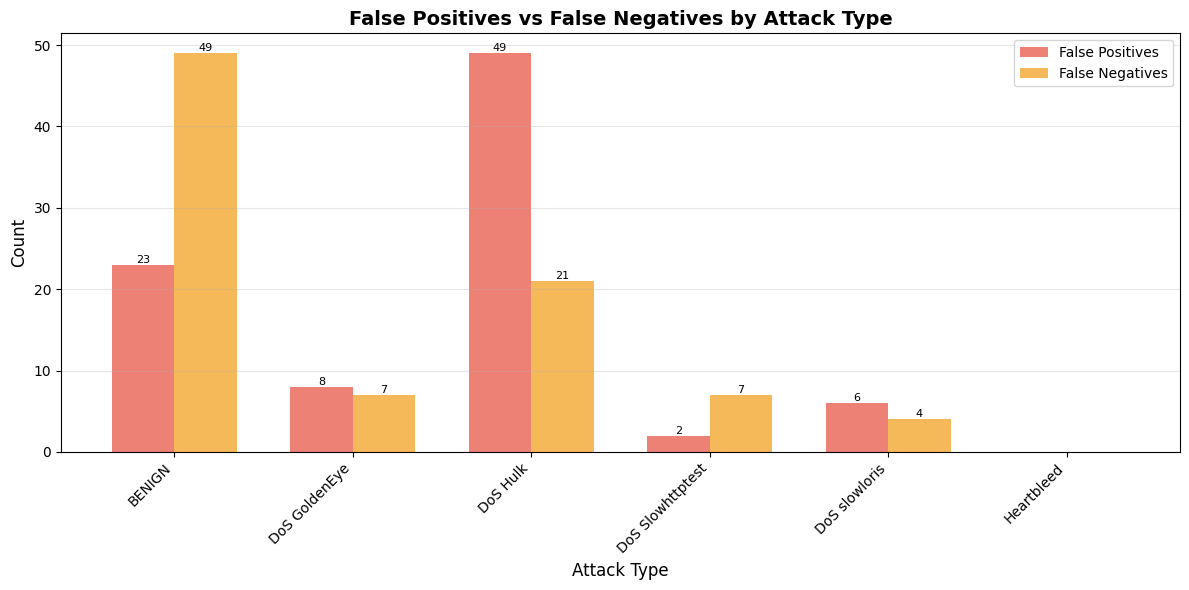

In [72]:
# False Positives vs False Negatives Analysis

# Calculate FP and FN for each class
false_positives_rf = cm_rf.sum(axis=0) - np.diag(cm_rf)  # Sum of column - diagonal
false_negatives_rf = cm_rf.sum(axis=1) - np.diag(cm_rf)  # Sum of row - diagonal
true_positives_rf = np.diag(cm_rf)
true_negatives_rf = cm_rf.sum() - (false_positives_rf + false_negatives_rf + true_positives_rf)

# Create summary table
fp_fn_rf = pd.DataFrame({
    'Attack Type': target_names,
    'True Positives': true_positives_rf,
    'False Positives': false_positives_rf,
    'False Negatives': false_negatives_rf,
    'FP Rate': false_positives_rf / (false_positives_rf + true_negatives_rf) if (false_positives_rf + true_negatives_rf).any() else 0,
    'FN Rate': false_negatives_rf / (false_negatives_rf + true_positives_rf)
})

print("\nFalse Positives and False Negatives by Class:")
display(fp_fn_rf)

# Overall FP and FN
total_fp = false_positives_rf.sum()
total_fn = false_negatives_rf.sum()
total_predictions = cm_rf.sum()

print(f"\nOverall Statistics:")
print(f"  Total False Positives: {total_fp:,} ({total_fp/total_predictions*100:.2f}%)")
print(f"  Total False Negatives: {total_fn:,} ({total_fn/total_predictions*100:.2f}%)")

# Visualize FP vs FN
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(target_names))
width = 0.35

bars1 = ax.bar(x - width/2, false_positives_rf, width, label='False Positives', color='#e74c3c', alpha=0.7)
bars2 = ax.bar(x + width/2, false_negatives_rf, width, label='False Negatives', color='#f39c12', alpha=0.7)

ax.set_xlabel('Attack Type', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('False Positives vs False Negatives by Attack Type', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(target_names, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height):,}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# 4. Comparative Performance Analysis
## 4.1. Model Comparison

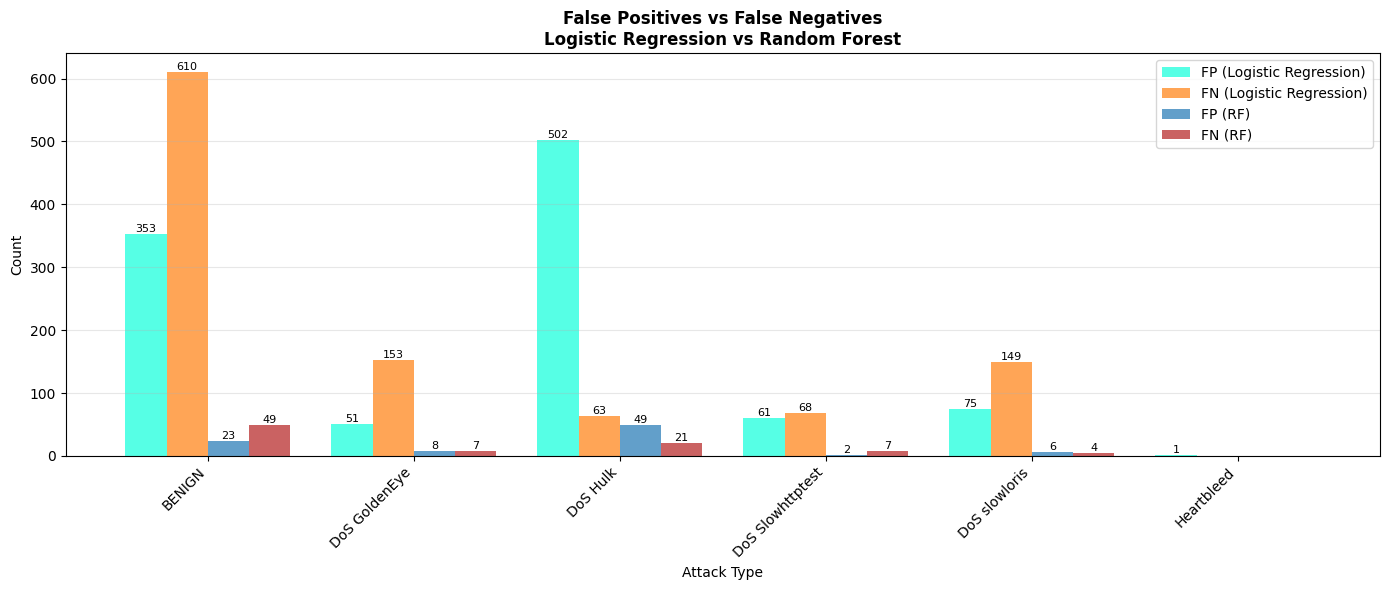

In [83]:
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(target_names))
width = 0.2

# Logistic Regression
bars_fp = ax.bar(x - width*1.5, false_positives, width,
                 label='FP (Logistic Regression)', color="#0effdb", alpha=0.7)
bars_fn = ax.bar(x - width*0.5, false_negatives, width,
                 label='FN (Logistic Regression)', color="#ff7f0e", alpha=0.7)

# Random Forest
bars_fp_rf = ax.bar(x + width*0.5, false_positives_rf, width,
                    label='FP (RF)', color="#1f77b4", alpha=0.7)
bars_fn_rf = ax.bar(x + width*1.5, false_negatives_rf, width,
                    label='FN (RF)', color="#b41f1f", alpha=0.7)

ax.set_xlabel('Attack Type')
ax.set_ylabel('Count')
ax.set_title('False Positives vs False Negatives\nLogistic Regression vs Random Forest',
             fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels(target_names, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Value labels
for bars in [bars_fp, bars_fn, bars_fp_rf, bars_fn_rf]:
    for bar in bars:
        h = bar.get_height()
        if h > 0:
            ax.text(bar.get_x() + bar.get_width()/2, h,
                    int(h), ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
## False Alarm Rate (FAR)
# Logistic Regression

total_negatives_lr = true_negatives + false_positives
far_per_class_lr = false_positives / total_negatives_lr
far_df_lr = pd.DataFrame({
    'Attack Type': target_names,
    'False Alarm Rate (FAR)': far_per_class_lr
})

absolute_total_negatives_lr = total_negatives_lr.sum()
absolute_false_positives_lr = false_positives.sum()
absolute_far_lr = absolute_false_positives_lr / absolute_total_negatives_lr

print(f"\nOverall False Alarm Rate (FAR) for Logistic Regression: {absolute_far_lr:.4f} ({absolute_far_lr*100:.2f}%)")

print("\nFalse Alarm Rate (FAR) per Class for Logistic Regression:")
display(far_df_lr)

# Random Forest

total_negatives_rf = true_negatives_rf + false_positives_rf
far_per_class_rf = false_positives_rf / total_negatives_rf
far_df_rf = pd.DataFrame({
    'Attack Type': target_names,
    'False Alarm Rate (FAR)': far_per_class_rf
})

absolute_total_negatives_rf = total_negatives_rf.sum()
absolute_false_positives_rf = false_positives_rf.sum()
absolute_far_rf = absolute_false_positives_rf / absolute_total_negatives_rf

print(f"\nOverall False Alarm Rate (FAR) for Random Forest: {absolute_far_rf:.4f} ({absolute_far_rf*100:.2f}%)")

print("\nFalse Alarm Rate (FAR) per Class for Random Forest:")
display(far_df_rf)



Overall False Alarm Rate (FAR) for Logistic Regression: 0.0011 (0.11%)

False Alarm Rate (FAR) per Class for Logistic Regression:


,Attack Type,False Alarm Rate (FAR)
0,BENIGN,0.0093
1,DoS GoldenEye,0.0003
2,DoS Hulk,0.0034
3,DoS Slowhttptest,0.0003
4,DoS slowloris,0.0004
5,Heartbleed,0.0000



Overall False Alarm Rate (FAR) for Random Forest: 0.0001 (0.01%)

False Alarm Rate (FAR) per Class for Random Forest:


,Attack Type,False Alarm Rate (FAR)
0,BENIGN,0.0006
1,DoS GoldenEye,0.0000
2,DoS Hulk,0.0003
3,DoS Slowhttptest,0.0000
4,DoS slowloris,0.0000
5,Heartbleed,0.0000
